### RFM 기법
- 비지도 학습을 통한 활용 방법
- 고객 세분화를 통한 타깃 마케팅
- Recency (R), Frequency (F), Monetary value (M)
- Recency: 가장 최근 상품 구입 일에서 오늘까지의 기간
- Frequency: 상품 구매 횟수
- Monetary: 총 구매 금액

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_csv("sales_data.csv", encoding="unicode_escape")

In [2]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [3]:
retail_df["InvoiceDate"] = pd.to_datetime(retail_df["InvoiceDate"])

In [4]:
# 데이터 셋 NULL 개수 확인
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 분석의 효율성을 위해 이상치 및 누락값 제거

In [5]:
retail_df = retail_df[retail_df["Quantity"] > 0]
retail_df = retail_df[retail_df["UnitPrice"] > 0]
retail_df = retail_df[retail_df["CustomerID"].notnull()]

print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
# 영국을 제외하고 다른 국가 데이터 삭제
retail_df = retail_df[retail_df["Country"] == "United Kingdom"]

print(retail_df.shape)

(354321, 8)


### RFM 데이터 가공

In [7]:
# unitprice x quantity 곱해서 주문 금액 데이터 생성
retail_df["sale_amount"] = retail_df["Quantity"] * retail_df["UnitPrice"]
retail_df["CustomerID"] = retail_df["CustomerID"].astype(int)

In [8]:
print(retail_df["CustomerID"].value_counts().head())
print(retail_df.groupby("CustomerID")["sale_amount"].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [9]:
# 몇몇 특정 고객이 많은 주문 건수와 금액도 가지고 있음
# 해당 데이터는 주문번호와 상품코드 레벨의 식별자 InvoiceNo, StockCode가 1에 가까운 식별자
retail_df.groupby(["InvoiceNo", "StockCode"])["InvoiceNo"].count().mean()

1.028702077315023

In [10]:
# DataFrame의 groupby() multiple 연산을 위해 agg() 사용
# Recency는 InvoiceDate 칼럼의 max() 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count()
# Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    "InvoiceDate": "max", 
    "InvoiceNo": "count", 
    "sale_amount": "sum"
}

cust_df = retail_df.groupby("CustomerID").agg(aggregations)

# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {"InvoiceDate": "Recency", 
                                    "InvoiceNo": "Frequency", 
                                    "sale_amount": "Monetary"})

cust_df = cust_df.reset_index()
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


In [11]:
import datetime as dt

In [12]:
cust_df["Recency"] = dt.datetime(2011, 12, 10) - cust_df["Recency"]
cust_df["Recency"] = cust_df["Recency"].apply(lambda x: x.days + 1)

print("cust_df 로우와 칼럼", cust_df.shape)
cust_df.head()

cust_df 로우와 칼럼 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


In [ ]:
# Recency: 고객이 가장 최근 주문한 날짜 
# 오늘날짜 기준으로 - 가장최근 주문일자 빼기 
# 온라인 현재 날짜 +1로 데이터 내의 가장 최근
# cust_df["Recency"]= cust_df["Recency"].astype(str)

# cust_df["Recency"]=cust_df["Recency"].str.slice(start=0, stop=3)
# cust_df["Recency"] = cust_df["Recency"].str.extract(r"(\d+)") # 숫자만 정규식 추출
# cust_df["Recency"]= cust_df["Recency"].astype(int)
# cust_df["Recency"]= cust_df["Recency"] + 1

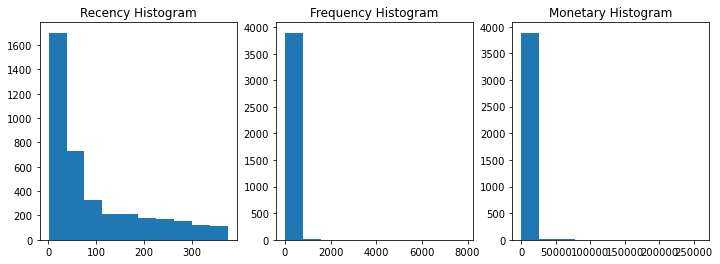

In [13]:
# 각 RFM 데이터 분포 확인
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax1.set_title("Recency Histogram")
ax1.hist(cust_df["Recency"])

ax2.set_title("Frequency Histogram")
ax2.hist(cust_df["Frequency"])

ax3.set_title("Monetary Histogram")
ax3.hist(cust_df["Monetary"])

plt.show()

In [14]:
cust_df[["Recency", "Frequency", "Monetary"]].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


### 데이터의 왜곡 정도가 매우 높은 경우는 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화 수행
- 따라서 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균 수행

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [19]:
X_features = cust_df[["Recency", "Frequency", "Monetary"]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_label"] = labels

print("실루엣 스코어: {0:.3f}".format(silhouette_score(X_features_scaled, labels)))

C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 스코어: 0.592


- 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592

In [24]:
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 개수들의 리스트를 받아서, 각 개수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 개수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링을 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title("Number of Cluster : " + str(n_cluster) + "\n" \
                           "Silhouette Score : " + str(round(sil_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([]) # Clear the y axis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 개수별로 fill_betweenx() 형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default 

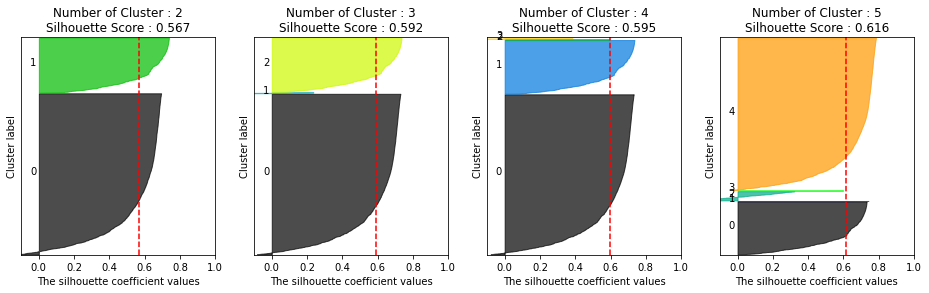

In [25]:
# 군집별 실루엣 계수는?
visualize_silhouette([2, 3, 4, 5], X_features_scaled)

- 비지도학습 알고리즘의 하나인 군집화의 기능적 의미는 숨어있는 새로운 집단을 발견하는 것
- 새로운 군집 내의 데이터 값을 분석하고 이해함으로써 이 집단에 새로운 의미를 부여할 수 있음
- 데이터의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(Log)를 적용하는 로그 변환
- 전체 데이터 로그 변환 뒤 K-평균 알고리즘 적용

In [26]:
cust_df

,CustomerID,Recency,Frequency,Monetary,cluster_label
0,12346,326,1,77183.60,1
1,12747,3,103,4196.01,0
2,12748,1,4595,33719.73,1
3,12749,4,199,4090.88,0
4,12820,4,59,942.34,0
...,...,...,...,...,...
3915,18280,278,10,180.60,2
3916,18281,181,7,80.82,2
3917,18282,8,12,178.05,0
3918,18283,4,756,2094.88,0


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df["Recency_log"] = np.log1p(cust_df["Recency"])
cust_df["Frequency_log"] = np.log1p(cust_df["Frequency"])
cust_df["Monetary_log"] = np.log1p(cust_df["Monetary"])

# Log Transformation 데이터에 StandardScaler 적용
X_features_log = cust_df[["Recency_log", "Frequency_log", "Monetary_log"]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X_features_log)
cust_df["cluster_label_log"] = labels

print("실루엣 스코어: {0:.3f}".format(silhouette_score(X_features_log, labels)))

C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 스코어: 0.398


- 실루엣 점수의 절대치가 중요한 것이 아니라 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 중요

C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default 

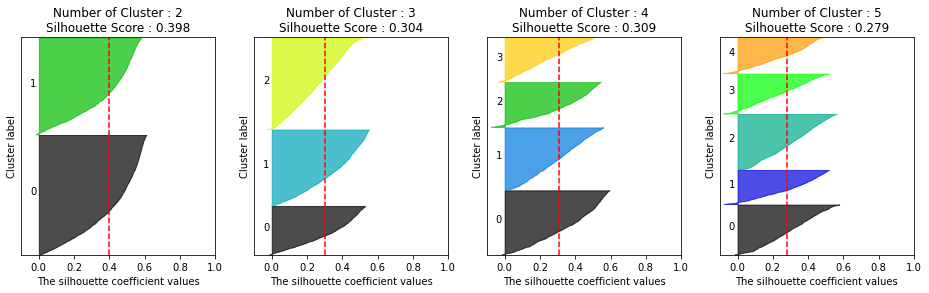

In [30]:
# 군집별 실루엣 계수는?
visualize_silhouette([2,3,4,5], X_features_log)

### 군집화를 통해서 인사이트를 추출해 보자!

In [31]:
cust_df

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log,cluster_label_log
0,12346,326,1,77183.60,1,5.789960,0.693147,11.253955,0
1,12747,3,103,4196.01,0,1.386294,4.644391,8.342128,1
2,12748,1,4595,33719.73,1,0.693147,8.432942,10.425868,1
3,12749,4,199,4090.88,0,1.609438,5.298317,8.316760,1
4,12820,4,59,942.34,0,1.609438,4.094345,6.849427,1
...,...,...,...,...,...,...,...,...,...
3915,18280,278,10,180.60,2,5.631212,2.397895,5.201806,0
3916,18281,181,7,80.82,2,5.204007,2.079442,4.404522,0
3917,18282,8,12,178.05,0,2.197225,2.564949,5.187665,0
3918,18283,4,756,2094.88,0,1.609438,6.629363,7.647729,1


In [32]:
cust_df.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'cluster_label',
       'Recency_log', 'Frequency_log', 'Monetary_log', 'cluster_label_log'],
      dtype='object')

In [33]:
cust_dfsp = cust_df[["Recency", "Frequency", "Monetary", "cluster_label", "cluster_label_log"]]

In [34]:
cust_dfsp

,Recency,Frequency,Monetary,cluster_label,cluster_label_log
0,326,1,77183.60,1,0
1,3,103,4196.01,0,1
2,1,4595,33719.73,1,1
3,4,199,4090.88,0,1
4,4,59,942.34,0,1
...,...,...,...,...,...
3915,278,10,180.60,2,0
3916,181,7,80.82,2,0
3917,8,12,178.05,0,0
3918,4,756,2094.88,0,1


In [35]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80


In [36]:
cust_lb = cust_df[["CustomerID", "cluster_label", "cluster_label_log"]]

In [37]:
cust_rtlb = pd.merge(retail_df, cust_lb, how="inner")

In [38]:
cust_rtlb

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount,cluster_label,cluster_label_log
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2,1
...,...,...,...,...,...,...,...,...,...,...,...
354316,581416,22809,SET OF 6 T-LIGHTS SANTA,1,2011-12-08 14:58:00,2.95,14569,United Kingdom,2.95,0,1
354317,581416,22807,SET OF 6 T-LIGHTS TOADSTOOLS,2,2011-12-08 14:58:00,1.25,14569,United Kingdom,2.50,0,1
354318,581416,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-12-08 14:58:00,2.10,14569,United Kingdom,2.10,0,1
354319,581416,22809,SET OF 6 T-LIGHTS SANTA,2,2011-12-08 14:58:00,2.95,14569,United Kingdom,5.90,0,1


- 전체 데이터 라벨을 Merge 하고 Description 데이터를 탐색해 보자!

In [39]:
cust_cluster_label = cust_rtlb.groupby(["cluster_label"])["Description"].agg(lambda x: " ".join(set(x)))
cust_cluster_label_log = cust_rtlb.groupby(["cluster_label_log"])["Description"].agg(lambda x: " ".join(set(x)))

In [40]:
cust_cluster_label = cust_cluster_label.to_frame()

In [41]:
cust_cluster_label_log = cust_cluster_label_log.to_frame()

In [42]:
cust_cluster_label.reset_index(inplace=True)
cust_cluster_label_log.reset_index(inplace=True)

In [43]:
cust_cluster_label["Description"].iloc[0]

'NUMBER TILE COTTAGE GARDEN 9 WRAP VINTAGE PETALS  DESIGN SET/4 SKULL BADGES PINK CHRYSANTHEMUMS ART FLOWER PARISIENNE JEWELLERY DRAWER  SQUARE CHERRY BLOSSOM CABINET CHRYSANTHEMUM SKETCHBOOK  PINK BITTY LIGHT CHAIN PURPLE BOUDICCA LARGE BRACELET ORIGAMI VANILLA INCENSE/CANDLE SET  BOTANICAL LAVENDER BIRTHDAY CARD BLACK SIL\'T SQU CANDLE PLATE  WOODLAND STORAGE BOX SMALL VEGETABLE MAGNETIC  SHOPPING LIST TOOL BOX SOFT TOY  VINTAGE UNION JACK CUSHION COVER STARFISH SOAP DISH BOX OF VINTAGE JIGSAW BLOCKS  HANGING CHICK CREAM DECORATION RED PEONY TABLE CLOCK LARGE PARLOUR PICTURE FRAME ASSTD MULTICOLOUR CIRCLES MUG GREEN POLKADOT BOWL SET OF 16 VINTAGE SKY BLUE CUTLERY SET/3 DECOUPAGE STACKING TINS WHITE ANEMONE ARTIFICIAL FLOWER CHILDRENS TOY COOKING UTENSIL SET EMBOSSED HEART TRINKET BOX FENG SHUI PILLAR CANDLE PAPER CHAIN KIT EMPIRE SWEETHEART BIRD HOUSE SET OF 4 CAROUSEL PLACEMATS  BLUE WIRE SPIRAL CANDLE HOLDER NUMBER TILE VINTAGE FONT 8 QUEEN OF THE SKIES HOLIDAY PURSE  SMALL FOLKAR

- 주문 데이터들이 붙여진 상태
- 카운팅
- 유사도
- 워드 클라우드 시각화
- 군집별로에 대한 인사이트를 볼 수 있다.

### nltk로 인사이트 뽑기!
- 형태소로 나누기

In [44]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

word_tokenize(cust_cluster_label["Description"].iloc[0])

['NUMBER',
 'TILE',
 'COTTAGE',
 'GARDEN',
 '9',
 'WRAP',
 'VINTAGE',
 'PETALS',
 'DESIGN',
 'SET/4',
 'SKULL',
 'BADGES',
 'PINK',
 'CHRYSANTHEMUMS',
 'ART',
 'FLOWER',
 'PARISIENNE',
 'JEWELLERY',
 'DRAWER',
 'SQUARE',
 'CHERRY',
 'BLOSSOM',
 'CABINET',
 'CHRYSANTHEMUM',
 'SKETCHBOOK',
 'PINK',
 'BITTY',
 'LIGHT',
 'CHAIN',
 'PURPLE',
 'BOUDICCA',
 'LARGE',
 'BRACELET',
 'ORIGAMI',
 'VANILLA',
 'INCENSE/CANDLE',
 'SET',
 'BOTANICAL',
 'LAVENDER',
 'BIRTHDAY',
 'CARD',
 'BLACK',
 "SIL'T",
 'SQU',
 'CANDLE',
 'PLATE',
 'WOODLAND',
 'STORAGE',
 'BOX',
 'SMALL',
 'VEGETABLE',
 'MAGNETIC',
 'SHOPPING',
 'LIST',
 'TOOL',
 'BOX',
 'SOFT',
 'TOY',
 'VINTAGE',
 'UNION',
 'JACK',
 'CUSHION',
 'COVER',
 'STARFISH',
 'SOAP',
 'DISH',
 'BOX',
 'OF',
 'VINTAGE',
 'JIGSAW',
 'BLOCKS',
 'HANGING',
 'CHICK',
 'CREAM',
 'DECORATION',
 'RED',
 'PEONY',
 'TABLE',
 'CLOCK',
 'LARGE',
 'PARLOUR',
 'PICTURE',
 'FRAME',
 'ASSTD',
 'MULTICOLOUR',
 'CIRCLES',
 'MUG',
 'GREEN',
 'POLKADOT',
 'BOWL',
 'SET',
 '

In [45]:
from nltk.tokenize import RegexpTokenizer

retokenize = RegexpTokenizer("[\w]+")

In [46]:
retokenize.tokenize(cust_cluster_label["Description"].iloc[0])

['NUMBER',
 'TILE',
 'COTTAGE',
 'GARDEN',
 '9',
 'WRAP',
 'VINTAGE',
 'PETALS',
 'DESIGN',
 'SET',
 '4',
 'SKULL',
 'BADGES',
 'PINK',
 'CHRYSANTHEMUMS',
 'ART',
 'FLOWER',
 'PARISIENNE',
 'JEWELLERY',
 'DRAWER',
 'SQUARE',
 'CHERRY',
 'BLOSSOM',
 'CABINET',
 'CHRYSANTHEMUM',
 'SKETCHBOOK',
 'PINK',
 'BITTY',
 'LIGHT',
 'CHAIN',
 'PURPLE',
 'BOUDICCA',
 'LARGE',
 'BRACELET',
 'ORIGAMI',
 'VANILLA',
 'INCENSE',
 'CANDLE',
 'SET',
 'BOTANICAL',
 'LAVENDER',
 'BIRTHDAY',
 'CARD',
 'BLACK',
 'SIL',
 'T',
 'SQU',
 'CANDLE',
 'PLATE',
 'WOODLAND',
 'STORAGE',
 'BOX',
 'SMALL',
 'VEGETABLE',
 'MAGNETIC',
 'SHOPPING',
 'LIST',
 'TOOL',
 'BOX',
 'SOFT',
 'TOY',
 'VINTAGE',
 'UNION',
 'JACK',
 'CUSHION',
 'COVER',
 'STARFISH',
 'SOAP',
 'DISH',
 'BOX',
 'OF',
 'VINTAGE',
 'JIGSAW',
 'BLOCKS',
 'HANGING',
 'CHICK',
 'CREAM',
 'DECORATION',
 'RED',
 'PEONY',
 'TABLE',
 'CLOCK',
 'LARGE',
 'PARLOUR',
 'PICTURE',
 'FRAME',
 'ASSTD',
 'MULTICOLOUR',
 'CIRCLES',
 'MUG',
 'GREEN',
 'POLKADOT',
 'BOWL'

In [52]:
retokenize.tokenize(cust_cluster_label_log["Description"].iloc[0])

['NUMBER',
 'TILE',
 'COTTAGE',
 'GARDEN',
 '9',
 'WRAP',
 'VINTAGE',
 'PETALS',
 'DESIGN',
 'SET',
 '4',
 'SKULL',
 'BADGES',
 'PINK',
 'BITTY',
 'LIGHT',
 'CHAIN',
 'SQUARE',
 'CHERRY',
 'BLOSSOM',
 'CABINET',
 'PARISIENNE',
 'JEWELLERY',
 'DRAWER',
 'CHRYSANTHEMUM',
 'SKETCHBOOK',
 'PURPLE',
 'BOUDICCA',
 'LARGE',
 'BRACELET',
 'ORIGAMI',
 'VANILLA',
 'INCENSE',
 'CANDLE',
 'SET',
 'BOTANICAL',
 'LAVENDER',
 'BIRTHDAY',
 'CARD',
 'WOODLAND',
 'STORAGE',
 'BOX',
 'SMALL',
 'TOOL',
 'BOX',
 'SOFT',
 'TOY',
 'VINTAGE',
 'UNION',
 'JACK',
 'CUSHION',
 'COVER',
 'STARFISH',
 'SOAP',
 'DISH',
 'HANGING',
 'CHICK',
 'CREAM',
 'DECORATION',
 'BOX',
 'OF',
 'VINTAGE',
 'JIGSAW',
 'BLOCKS',
 'RED',
 'PEONY',
 'TABLE',
 'CLOCK',
 'LARGE',
 'PARLOUR',
 'PICTURE',
 'FRAME',
 'ASSTD',
 'MULTICOLOUR',
 'CIRCLES',
 'MUG',
 'GREEN',
 'POLKADOT',
 'BOWL',
 'SET',
 'OF',
 '16',
 'VINTAGE',
 'SKY',
 'BLUE',
 'CUTLERY',
 'SET',
 '3',
 'DECOUPAGE',
 'STACKING',
 'TINS',
 'CHILDRENS',
 'TOY',
 'COOKING',


- nltk에서 제공하는 함수들

In [66]:
cust_cluster_label_log["Description"].iloc[2]

IndexError: single positional indexer is out-of-bounds

In [67]:
from nltk import Text

text_st0 = Text(retokenize.tokenize(cust_cluster_label["Description"].iloc[0]))
text_st1 = Text(retokenize.tokenize(cust_cluster_label["Description"].iloc[1]))
text_st2 = Text(retokenize.tokenize(cust_cluster_label["Description"].iloc[2]))

text_log0 = Text(retokenize.tokenize(cust_cluster_label_log["Description"].iloc[0]))
text_log1 = Text(retokenize.tokenize(cust_cluster_label_log["Description"].iloc[1]))
# text_log2 = Text(retokenize.tokenize(cust_cluster_label_log["Description"].iloc[2]))

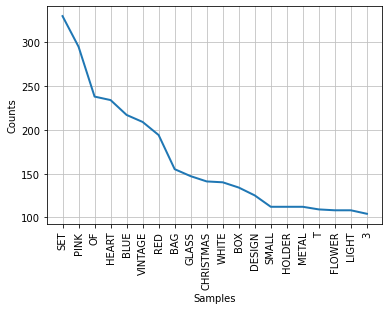

AxesSubplot(0.125,0.125;0.775x0.755)


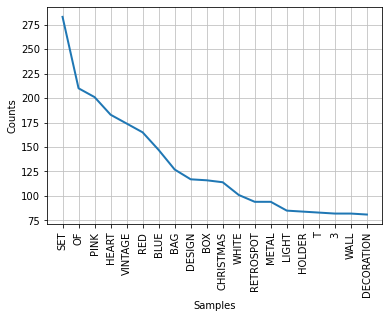

AxesSubplot(0.125,0.125;0.775x0.755)


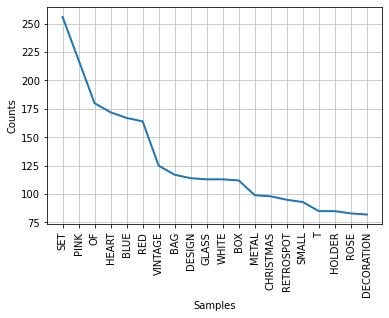

AxesSubplot(0.125,0.125;0.775x0.755)


In [68]:
print(text_st0.plot(20))
print(text_st1.plot(20))
print(text_st2.plot(20))

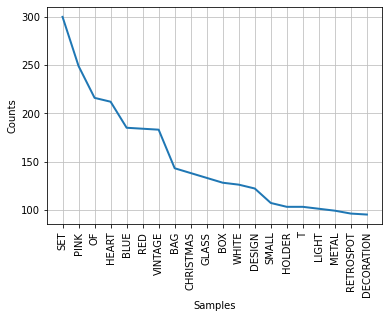

AxesSubplot(0.125,0.125;0.775x0.755)


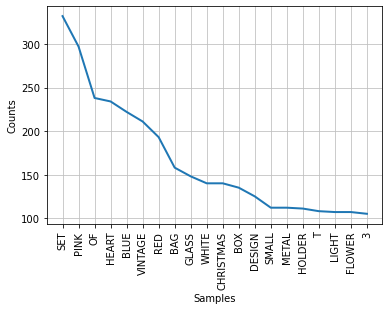

AxesSubplot(0.125,0.125;0.775x0.755)


In [69]:
print(text_log0.plot(20))
print(text_log1.plot(20))
# print(text_log2.plot(20))

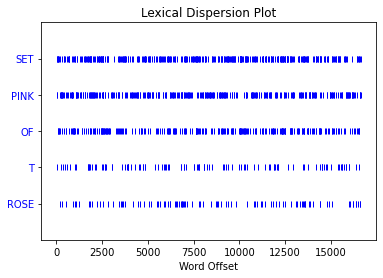

In [71]:
text_st0.dispersion_plot(["SET", "PINK", "OF", "T", "ROSE"])

In [72]:
# 내가 원하는 형태소가 어떤 구조로 되어있나
text_st0.concordance("ROSE")

Displaying 25 of 97 matches:
NVITES DINOSAURS WEEKEND BAG VINTAGE ROSE PAISLEY WHITE WOOD GARDEN PLANT LADD
RENCH BLUE METAL DOOR SIGN 4 12 PINK ROSE PEG PLACE SETTINGS MILK PAN PINK POL
E OFFICE FLAG OF ST GEORGE SOFT PINK ROSE TOWEL COTE D AZURE NECKLACE CHILDREN
SUES RETRO PINK BALL ASHTRAY ENGLISH ROSE SMALL SCENTED FLOWER SET OF 4 PANTRY
 MUM S KITCHEN CLOCK PACK 20 ENGLISH ROSE PAPER NAPKINS MOCK LOBSTER FRIDGE MA
 WHITE KEEP CLEAN BULLET BIN CROCHET ROSE PURSE WITH SUEDE BACK FANNY S REST S
GE TOKYO 78 ORANGE TV TRAY TABLE RED ROSE AND LACE C COVER WHITE FRANGIPANI HA
L ZINC GLASS CANDLEHOLDER MINT GREEN ROSE TOWEL DINOSAUR PARTY BAG STICKER SET
R BLUE DRAWER KNOB ACRYLIC EDWARDIAN ROSE 3 WICK MORRIS BOX CANDLE JAZZ HEARTS
TURQUOISE PINK SWEETHEART BRACELET 4 ROSE PINK DINNER CANDLES 4 VANILLA BOTANI
 METAL HERB GERDEN CONTAINER ENGLISH ROSE NOTEBOOK A6 SIZE BLUE PAPER PARASOL 
HADE ASS COL CIRCLE MOBILE PORCELAIN ROSE SMALL NEW ENGLAND MUG W GIFT BOX VIN
E KEEPSAKE BOX PINK FLO

In [73]:
text_st0.similar("ROSE")

heart lavender red lily wrap set chrysanthemums flower vanilla black
font retrospot wall fun victorian leaf parasol butterfly ivory
notebook


In [74]:
# 두 개의 관계
text_st0.common_contexts(["RED", "ROSE"])

vintage_paisley vintage_cutlery


### 워드 클라우드도 가능하다!
- vocab 메서드 추출

In [75]:
rt0 = text_st0.vocab()

In [76]:
rt0

FreqDist({'SET': 330, 'PINK': 295, 'OF': 238, 'HEART': 234, 'BLUE': 217, 'VINTAGE': 209, 'RED': 194, 'BAG': 155, 'GLASS': 147, 'CHRISTMAS': 141, ...})

In [78]:
from nltk import FreqDist
from nltk.tag import pos_tag

text_tk0 = pos_tag(retokenize.tokenize(cust_cluster_label["Description"].iloc[0]))
order_list = [t[0] for t in text_tk0 if t[1]=="NNP" and t[0]]
od_names0 = FreqDist(order_list)

In [79]:
# 수치가 들어간 데이터고 원하는 형태소만 출력했으니
od_names0.most_common(10) # 원하는 상위 워드만 출력도 가능하다!

[('SET', 330),
 ('PINK', 295),
 ('HEART', 234),
 ('BLUE', 217),
 ('VINTAGE', 209),
 ('RED', 192),
 ('OF', 179),
 ('BAG', 155),
 ('GLASS', 147),
 ('CHRISTMAS', 141)]

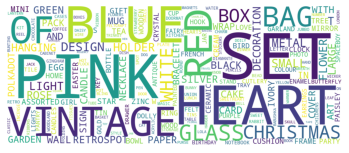

In [80]:
from wordcloud import WordCloud

wc = WordCloud(width=1200, height=500, background_color="white")
plt.imshow(wc.generate_from_frequencies(od_names0))
plt.axis("off")
plt.show()

### 코호트 분석 예시

In [81]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80


In [83]:
df = retail_df.dropna(subset=["CustomerID"])

In [84]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80


In [86]:
# 코호트에 필요한 월별 데이터 전처리
# 연도별/월별로 접근하려 한다.

def get_month(x): return dt.datetime(x.year, x.month, 1)

df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)
grouping = df.groupby(["CustomerID"])["InvoiceMonth"]
df["CohortMonth"] = grouping.transform("min")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40,2011-12-01,2011-05-01
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,2011-12-01,2010-12-01
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00,2011-12-01,2010-12-01
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80,2011-12-01,2010-12-01


In [87]:
def get_month_int(dframe, column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day

In [88]:
invoice_year, invoice_month, invoice_day = get_month_int(df, "InvoiceMonth")
cohort_year, cohort_month, _ = get_month_int(df, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["CohortIndex"] = year_diff*12 + month_diff + 1

In [90]:
grouping = df.groupby(["CohortMonth", "CohortIndex"])
cohort_data = grouping["CustomerID"].apply(pd.Series.nunique)

cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index="CohortMonth", columns="CohortIndex", values="CustomerID")

In [91]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### RFM을 가지고 단순히 군집화하는 게 아니라 도메인 지식을 가지고 그룹을 만들 수 있다!

In [92]:
rfm = cust_df[["Recency", "Frequency", "Monetary"]]

In [93]:
rfm

,Recency,Frequency,Monetary
0,326,1,77183.60
1,3,103,4196.01
2,1,4595,33719.73
3,4,199,4090.88
4,4,59,942.34
...,...,...,...
3915,278,10,180.60
3916,181,7,80.82
3917,8,12,178.05
3918,4,756,2094.88


- 도메인을 가지고 접근한다.
- F 많이 구매하는 사람
- R 가장 최근에 구매하는 사람

---
- 다 사용하는 것이 아니라
- R, F를 가지고 사용한다면
- 최근에 들어와서 많이 사는 고객
- 최근에 들어와서 하나만 사는 고객
- 주기별로 들어와서 사는 고객
- 휴면 고객
- 기타 등등
- 분석가가 정의를 해서 이걸 하나의 데이터를 변경을 해서 인사이트를 뽑을 수 있다.

In [94]:
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])

C:\Users\doram\AppData\Local\Temp\ipykernel_24252\869517922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])


In [95]:
rfm

,Recency,Frequency,Monetary,recency_score
0,326,1,77183.60,1
1,3,103,4196.01,5
2,1,4595,33719.73,5
3,4,199,4090.88,5
4,4,59,942.34,5
...,...,...,...,...
3915,278,10,180.60,1
3916,181,7,80.82,1
3917,8,12,178.05,5
3918,4,756,2094.88,5


In [96]:
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[5,4,3,2,1])

C:\Users\doram\AppData\Local\Temp\ipykernel_24252\1355637689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[5,4,3,2,1])


In [97]:
# 스코어를 더하기에는 로직상 무리가 있으니 문자로 합쳤다.
rfm["rfm_segment"] = rfm["recency_score"].astype("str") + rfm["frequency_score"].astype("str")

C:\Users\doram\AppData\Local\Temp\ipykernel_24252\3257464319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["rfm_segment"] = rfm["recency_score"].astype("str") + rfm["frequency_score"].astype("str")


In [99]:
seg_map = {
    r"[1-2][1-2]": "수면 고객", 
    r"5[4-5]": "VVIP", 
    r"33": "관심 타겟 고객"
}

In [100]:
rfm["rfm_segment"] = rfm["rfm_segment"].replace(seg_map, regex=True)

C:\Users\doram\AppData\Local\Temp\ipykernel_24252\2101101052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["rfm_segment"] = rfm["rfm_segment"].replace(seg_map, regex=True)


### 최종 데이터 분석 리포팅 과제
- 데이터 최종 리포팅에 필요한
- 데이터와 요구사항 공유할 예정

---
### 프로젝트
- 네이버 카페에 올려주시고, 팀별로 팀 하나로, 개인은 개인이 올려주시면 됩니다.

---
### 학술제
- 뛰어난 발표 자료들은 -> 실제 현업 현직자들을 다 모셔와서 피드백을 드리는 시간을 가지려고 한다.